<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [44]:
#| hide
#| default_exp expectation_maximization.vis
# pdf:
#   toc: true
#   docx: default

In [45]:
#|hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from scholarly_infrastructure import logger, print
from thu_big_data_ml.help import plt, pio

In [47]:
#| hide
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# pio.renderers.default # 确保是 default
# pio.renderers

'notebook'

::: {.callout-important}
本文档具有一定的交互性，建议使用浏览器打开html文件，这样比pdf文件阅读体验更佳。
:::

## 第一题——一个例子理解 EM 算法 {#sec-1}

> 例9.1（三硬币模型）假设有3枚硬币，分别记作A，B，C.这些硬币正面出现的概率分别是，p和q.进行如下掷硬币试验：先掷硬币A，根据其结果选出硬币B或硬币C；正面选硬币B，反面选硬币C；然后掷选出的硬币，掷硬币的结果，出现正面记作1，出现反面记作0；独立地重复n次试验(这里，n=10)，观测结果如下:
>
> 1,1,0,1,0,0,1,0,1,1
>
> 假设只能观测到掷硬币的结果，不能观测掷硬币的过程.问如何估计三硬币正面出现的概率，即三硬币模型的参数。
>
> 题目:如例9.1的三硬币模型。假设观测数据不变，试选择不同的初值，例如，$\pi^{(0)}=0.46,p^{(0)}=0.55,q^{(0)}=0.67$,求模型参数$\theta=(\pi,p,q)$的极大似然估计。


### 审题 {#sec-1-analysis}

我们首先复习一下李航书上的内容和课件上的内容。

- 抽象来说，整个问题的框架是什么？

- 为什么不能直接求解？如果使用梯度下降方法来求解，为什么没有 EM 算法好？

- EM 算法的思想是什么？

- EM 算法 和其他交替 (alternating) 优化算法有什么区别？

- Jensen 不等式是什么？

- EM 算法的强大之处在哪里？
    - 注意

- EM 算法 和 迭代尺度法有没有关系？


复习之后，我们来看看题目询问的问题。本题需要我们尝试和李航书例题解答不同的初值来尝试求解。

首先 数据 如下

In [ ]:
import numpy as np
import plotly.express as px

In [48]:
X = np.array([1,1,0,1,0,0,1,0,1,1])
px.histogram(x=X, nbins=2)

In [49]:
pi, p, q = 0.46, 0.55, 0.67
px.bar(x=['π', 'p', 'q'], y=[pi, p, q], title='Bernoulli Distribution Parameters', labels={'x':'硬币A (决定抛B还是C), 硬币B, 硬币C', 'y': 'P(X=1)'})

接下来尝试使用 EM 算法来迭代求解这个“混合伯努利分布”极大似然估计。

### 解题 {#sec-1-solution}



#### 解法一：手工推导法（考试写解答题）

##### 第一轮迭代，我们有初始的参数值 $\theta_1 = (\pi_1, p_1, q_1)$

假如这个参数值当做真的参数值，我们可以算什么呢？

- 不完全数据的对数似然函数 $logP(X|\theta_1)$ 是可以计算的，虽然我们不能得到解析解，但是这个似然的值至少是可以计算的，可以知道我们现在这个参数估计的好不好。
- 如果我们有Z的具体值 (也就是每一个样本 $x_i$ 是来自硬币B还是C)，完全数据的 $logP(X, Z|\theta_1)$就能算出一个值，不过我们自然是没有 Z 的具体值，否则 $logP(X, Z|\theta)$ 可以直接极大似然估计$\theta$了。
- 但是我们有$\theta_1$, 而且我们有 $P(Z|X, \theta_1)$的计算公式，所以我们是可以估算出来，每一个样本 $x_i$ 既然等于1或者0，那么在我的$\theta_1$ 下 它来自Z的概率是多少。

--- 

所以我们首先来计算此概率。Z 无非 取值 1, 0 (硬币B,硬币C)， 所以根据贝叶斯公式

<!-- $$P(Z=1|X=x_i, \theta_1) = \eta P(X=x_i | Z=1, \theta_1) \times P(Z=1| \theta_1) = p_1^{x_i}(1-p_1)^{1-x_i} \times \pi_1$$ -->
$$
\begin{align}
P(Z=1|X=x_i, \theta_1) &= \eta P(X=x_i | Z=1, \theta_1) \times P(Z=1| \theta_1) \\
&= \eta p_1^{x_i}(1-p_1)^{1-x_i} \times \pi_1
\end{align}
$$
同理 $P(Z=1|X=x_i, \theta_1) = \eta q_1^{x_i}(1-q_1)^{1-x_i} \times (1-\pi_1)$

这个式子和 李航《统计学习方法》 9.5 式一致，我们使用了 $\eta$ 表示归一化参数, 也就是贝叶斯公式的分母。其中注意 $p_1^{x_i}(1-p_1)^{1-x_i}$ 无非就是 伯努利分布的概率密度函数，实际上是把 $x_i=0$ 和 $x_i=1$的情况合并在一起表示。

---

我们代入数值计算一下，按照上面列出的公式

In [50]:
def get_p_z_given_x_theta(X, pi, p, q):
    p_z_eq1_given_x_theta = (p**X) * ((1-p)**(1-X)) * pi
    p_z_eq0_given_x_theta = (q**X) * ((1-q)**(1-X)) * (1-pi)
    eta = 1/ (p_z_eq1_given_x_theta + p_z_eq0_given_x_theta)
    p_z_eq1_given_x = eta * p_z_eq1_given_x_theta
    p_z_eq0_given_x = eta * p_z_eq0_given_x_theta
    return p_z_eq1_given_x, p_z_eq0_given_x
p_z_eq1_given_x, p_z_eq0_given_x = get_p_z_given_x_theta(X, pi, p, q)
p_z_eq1_given_x


array([0.41151594, 0.41151594, 0.53738318, 0.41151594, 0.53738318,
       0.53738318, 0.41151594, 0.53738318, 0.41151594, 0.41151594])

上面的值意味着给定参数$\theta_1$时，每一个样本是被 硬币 B 得到的概率。
考试的时候，我们不需要每一个样本$x_i$都算一次，因为 $x_i$ 无非是0或1，我们只需要计算 $P(Z=1|X=0, \theta_1)$ 和 $P(Z=1|X=1, \theta_1)$


---

李航书上说这就完成了 **Expectation Step**，对于硬币这个混合伯努利分布模型确实到这一步可以算下一步 Maximization 了，但是我们这里把概念搞清楚一点。EM算法所求解的是Q函数，也就是一个期望，不只是 Z 的概率分布。

具体这个期望是谁的期望呢？要说明一个期望，第一需要知道采样这个期望的概率分布是什么分布，第二要知道期望想要知道的函数值是什么。
我们简单复习一下概率论的知识
<img src="image.png" alt="alt text" style="width: 30%;" />
本来期望的定义是对一个随机变量而言的，但是因为有这个基本公式，只要是另外一个随机变量是原本随机变量的函数关系，就可以用原本的随机变量的分布来采样函数值，得到目标随机变量的期望。

对于EM算法而言，经过Jensen不等式的推导，我们感兴趣的期望是$E(logP(Y, Z| \theta))$ 也就是 完全数据的对数使然函数，然后因为我们没有Z的确切值但是有Z的估计分布，所以我们可以用这个分布去采样，也就是关注的重点在于 $Q(\theta, \theta_i) = E_{Z|Y, \theta_i}(logP(Y, Z| \theta) | Y, \theta_i)$。

注意这里这个式子的概率论符号我认为是很有必要进行解释的，否则我们都无法知道我们到底在讨论什么。

- 首先 $Q(\theta, \theta_i)$的意思是右边这个式子中间内部使用了一些变量，但是这些变量最后都和最后的值无关，比如说被求和和积分“积掉了（reduce了）”，最后只有 $\theta_i$ （上一轮的参数估计值或者第一轮的先验）和变量$\theta$决定右边式子的值，据此下一步 Maximization 才能够优化 $\theta$ 。

- $E_{Z|Y, \theta_i}$, 下标代表用来估计期望的密度函数，李航书上写的是 $E_{Z}$，这个是指用来采样用的那个随机变量是Z，我们表达的更加精确，我们说的是密度函数是我们上面求出的 $P(Z|Y, \theta_i)$。 括号内的 $| Y, \theta_i)$ 竖线表示 **条件期望**，也是决定用来估计期望的密度函数的一个表示方法。


<img src="image-1.png" alt="alt text" style="width: 30%;" />

--- 

那为什么李航书上我们没有继续去求 $Q(\theta, \theta_i)$, 而是在 $P(Z|Y, \theta_i)$ 戛然而止了呢？

这是因为我们在**作业1** 已经详细推导过了 伯努利分布模型的 极大似然估计和贝叶斯估计，我们知道结论是什么，我们不需要再次推导一遍（还是稍有区别，因为Z不是固定值而是分布）。

我们已经知道 有了 $P(Z|Y, \theta_i)$ 的情况下，极大 $E_{Z|Y, \theta_i}(logP(Y, Z| \theta) | Y, \theta_i)$ 估计的结果，所以我们可以直接进入到 **Maximization Step**

---

首先极大似然估计 $\pi_{i+1}$ 这个硬币A伯努利分布的参数，如果Z是固定值，极大似然估计无非就是看看有多少个1多少个0，计算个频率即可，贝叶斯估计无非就是增加一个Beta分布的先验，先验的多几个1和0的统计结果罢了。现在Z是 $P(Z|Y, \theta_i)$，经过李航书上省略的推导，要最大化Expectation Step的期望，本质上无非就是计算频率的时候用Z的概率值来加权计算。所以
$$\pi_{i+1} = \frac{1}{N} \sum_{j=1}^{N} P(Z=1|X=x_j, \theta_i) $$

In [51]:
pi = p_z_eq1_given_x_theta.mean()
pi

0.23460000000000006

而p也是伯努利分布，表示B硬币的正面概率，如果你告诉我X数据里面哪些值是B抛出了，极大似然估计无非就是这个X数据的子集里面，0有多少个，1有多少个。但是我当然不知道Z的具体分配，我只有Z的估计的分布。李航书上再次省略了推导，但是很容易理解，如果我们要找到一个p最大化期望，本质上无非就是整个X我都统计0和1，不过每一个x_i的频率贡献是根据Z的概率值贡献加权的。所以

$$p_{i+1} = \frac{\sum_{j=1}^{N} P(Z=1|X=x_j, \theta_i) \cdot x_j}{ \sum_{j=1}^{N} P(Z=1|X=x_j, \theta_i)}  $$

同理

$$q_{i+1} = \frac{\sum_{j=1}^{N} P(Z=0|X=x_j, \theta_i) \cdot x_j}{ \sum_{j=1}^{N} P(Z=0|X=x_j, \theta_i)}  $$


In [52]:
p = sum(p_z_eq1_given_x_theta* X)/ sum(p_z_eq1_given_x_theta)
q = sum(p_z_eq0_given_x_theta* X)/ sum(p_z_eq0_given_x_theta)
p, q

(0.6470588235294118, 0.7528089887640449)

##### 第二轮迭代
同理

In [53]:
p_z_eq1_given_x, p_z_eq0_given_x = get_p_z_given_x_theta(X, pi, p, q)
pi = p_z_eq1_given_x_theta.mean()
p = sum(p_z_eq1_given_x_theta* X)/ sum(p_z_eq1_given_x_theta)
q = sum(p_z_eq0_given_x_theta* X)/ sum(p_z_eq0_given_x_theta)
pi, p, q

(0.23460000000000006, 0.6470588235294118, 0.7528089887640449)

我们发现我们已经获得了一个稳定的解，$\pi, p, q$已经稳定，收敛到到了局部最优值，因而EM算法结束。

## 第二题——混合高斯分布上使用 EM 算法{#sec-2}

题目如下
> 已知观测数据 -67, -48, 6, 8, 14, 16, 23, 24, 28, 29, 41, 49, 56, 60, 75，试估计两个分量的高斯混合模型的5个参数。

### 审题

In [54]:
import plotly.figure_factory as ff
from nbdev.showdoc import show_doc

In [55]:
# 已知观测数据
data = np.array([-67, -48, 6, 8, 14, 16, 23, 24, 28, 29, 41, 49, 56, 60, 75])
fig = px.histogram(x=data, 
                   marginal="box", # or violin, rug
        )
# hist_data = [data]
# group_labels = ['distplot'] # name of the dataset

# fig = ff.create_distplot(hist_data, group_labels)
fig

### 解题 {#sec-2-solution}


#### 解法一：手工推导法（考试写解答题）

上一题我们已经详细解释了EM算法，使用EM算法估计了 混合伯努利分布。

这一题是混合高斯分布，其实混合高斯分布的EM的公式是类似的，这一题两个分量也就是上一题的硬币A，我们也是先计算每一个样本属于哪个分量的概率  $P(Z|Y, \theta_i)$，然后使用概率作为加权，去极大似然估计参数 $\pi$。估计$\pi$的公式和上面完全一样，因为是伯努利分布。

而估计两个分量的高斯分布的参数的公式则和上面有所不同。高斯分布的极大似然估计，无非就是计算数据子集的均值和方差。而在EM当中，我们需要推导怎么极大化 Q函数，实际上对于高斯混合分布，和伯努利混合分布类似，得到的结论无非就是 以概率 $P(Z|Y, \theta_i)$ 加权 计算均值和方差。

由于上一题我们已经手算推导过，我们这一题不再重复，而是来探究一下**解法二：使用Python和机器学习库**，我们这一题来探究一下，在现实科研场景下，我们怎么使用EM算法，以混合高斯分布为例。

#### 解法二：使用Python和机器学习库（科研使用）


我们使用sklearn来使用EM算法来对高斯混合模型进行训练。

In [ ]:
from sklearn.mixture import GaussianMixture

In [58]:
GaussianMixture?

Init signature:
GaussianMixture(
    n_components=1,
    *,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='kmeans',
    weights_init=None,
    means_init=None,
    precisions_init=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10,
)
Docstring:     
Gaussian Mixture.

Representation of a Gaussian mixture model probability distribution.
This class allows to estimate the parameters of a Gaussian mixture
distribution.

Read more in the :ref:`User Guide <gmm>`.

.. versionadded:: 0.18

Parameters
----------
n_components : int, default=1
    The number of mixture components.

covariance_type : {'full', 'tied', 'diag', 'spherical'}, default='full'
    String describing the type of covariance parameters to use.
    Must be one of:

    - 'full': each component has its own general covariance matrix.
    - 'tied': all components share the same general covariance matrix.
    - 'diag': each co

In [59]:
# 将数据转换为二维数组，因为根据上面的文档，GMM需要二维输入
data_2d = data.reshape(-1, 1)

In [60]:
# 创建GMM模型，指定两个分量
gmm = GaussianMixture(n_components=2, 
                      random_state=0, verbose=2)

# 拟合模型
gmm.fit(data_2d)

Initialization 0
Initialization converged. time lapse 0.21671s	 lower bound -4.73756.


GaussianMixture(n_components=2, random_state=0, verbose=2)

我们看到GMM都还没开始，Initialization的结果就已经让它收敛了，这是因为 GMM 使用了 KMeans的结果来作为初始化。
我们再来试试随机初始化。

In [64]:
gmm = GaussianMixture(n_components=2, init_params = "random", 
                      random_state=0, verbose=2, verbose_interval=1)

# 拟合模型
gmm.fit(data_2d)

Initialization 0
  Iteration 1	 time lapse 0.01017s	 ll change inf
  Iteration 2	 time lapse 0.00344s	 ll change 0.00766
  Iteration 3	 time lapse 0.00336s	 ll change 0.02146
  Iteration 4	 time lapse 0.00226s	 ll change 0.04780
  Iteration 5	 time lapse 0.00037s	 ll change 0.04391
  Iteration 6	 time lapse 0.00031s	 ll change 0.01010
  Iteration 7	 time lapse 0.00032s	 ll change 0.00443
  Iteration 8	 time lapse 0.00135s	 ll change 0.00365
  Iteration 9	 time lapse 0.00378s	 ll change 0.00317
  Iteration 10	 time lapse 0.00309s	 ll change 0.00283
  Iteration 11	 time lapse 0.00342s	 ll change 0.00261
  Iteration 12	 time lapse 0.00346s	 ll change 0.00253
  Iteration 13	 time lapse 0.00258s	 ll change 0.00260
  Iteration 14	 time lapse 0.00032s	 ll change 0.00287
  Iteration 15	 time lapse 0.00030s	 ll change 0.00348
  Iteration 16	 time lapse 0.00041s	 ll change 0.00467
  Iteration 17	 time lapse 0.00313s	 ll change 0.00709
  Iteration 18	 time lapse 0.00334s	 ll change 0.01260
  Iter

GaussianMixture(init_params='random', n_components=2, random_state=0, verbose=2,
                verbose_interval=1)

这一次则是使用了22次迭代，EM算法才收敛。

我们来看看模型估计的结果是什么样的。

In [65]:
# 提取参数
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_
weights, means, covariances


(
    array([0.13317228, 0.86682772]),
    array([[-57.51107672],
       [ 32.98488751]]),
    array([[[ 90.24987868]],

       [[429.45832976]]])
)

mean和covariances就是估计出来的两个高斯分布分量的均值和协方差矩阵，因为这里是一维的，协方差矩阵只有一个元素就是方差。
weights则表示这两个分量分别占多少，也就是先抛一枚硬币A决定用哪个分量的这个概率。

我们可以可视化一下拟合出来的混合高斯分布，如下所示：

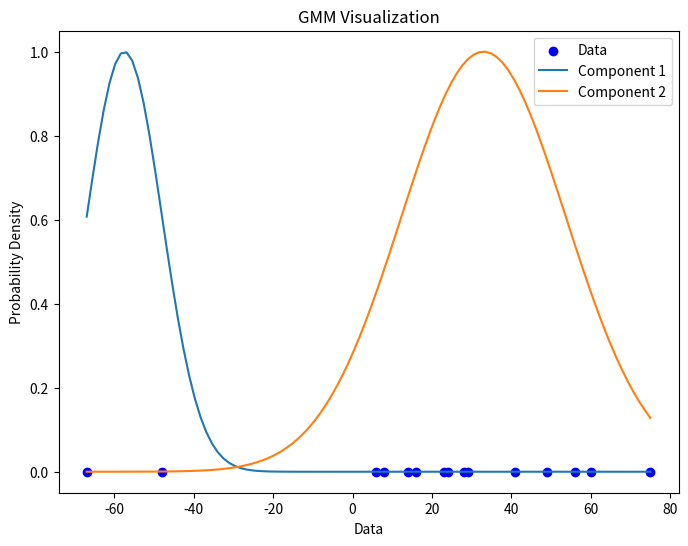

In [66]:
# 可视化数据和GMM模型
plt.figure(figsize=(8, 6))
plt.scatter(data, np.zeros_like(data), c='blue', label='Data')

# 绘制GMM模型的等高线
x = np.linspace(data.min(), data.max(), 100)
for i, (mean, cov) in enumerate(zip(means, covariances)):
    y = np.exp(-0.5 * ((x - mean[0]) ** 2 / cov[0, 0]))
    plt.plot(x, y, label=f'Component {i+1}')

plt.title('GMM Visualization')
plt.xlabel('Data')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

其中 `y = np.exp(-0.5 * ((x - mean[0]) ** 2 / cov[0, 0]))` 是高斯分布的密度函数。

我们还可以计算一下在这个参数下，每一个样本属于分量的概率。


In [67]:
gmm.predict_proba(data_2d)


array([[9.99956686e-01, 4.33138991e-05],
       [9.97627532e-01, 2.37246752e-03],
       [1.54227685e-10, 1.00000000e+00],
       [3.27141378e-11, 1.00000000e+00],
       [2.53066088e-13, 1.00000000e+00],
       [4.66651997e-14, 1.00000000e+00],
       [9.53724105e-17, 1.00000000e+00],
       [3.80184958e-17, 1.00000000e+00],
       [8.79579073e-19, 1.00000000e+00],
       [3.35616030e-19, 1.00000000e+00],
       [1.61505874e-24, 1.00000000e+00],
       [2.28568088e-28, 1.00000000e+00],
       [6.18648047e-32, 1.00000000e+00],
       [4.66887134e-34, 1.00000000e+00],
       [1.47644926e-42, 1.00000000e+00]])

我们可以看到，前两个样本有较高的概率属于第一个分量，而后面所有样本几乎百分之一百属于第二个分量。


---

sklearn库只能求解 一些有限的 机器学习模型，有没有通用的用来解决 EM 算法的 隐变量估计问题的算法呢？答案是肯定的。

```bash
pip install mixem
```

In [68]:
from mixem import em
from mixem.distribution import NormalDistribution

In [72]:
# 我们来定义分布
distributions = [
    NormalDistribution(mu=0, sigma=1),
    NormalDistribution(mu=0, sigma=1)
]

In [73]:
# 使用 0.5, 0.5 作为两个分量选择的初始值，开始EM算法
weights, distributions, log_likelihood = em(data, distributions, initial_weights=[0.5, 0.5])

iteration    0 (log-likelihood=nan): p(x|Φ) = nan*Norm[μ=nan, σ=nan] + nan*Norm[μ=nan, σ=nan]


然而很可惜，这个库似乎按照其官网教程并没有正确工作。我们下次再探索。

### 题目扩展问题





In [74]:
#| hide
import nbdev; nbdev.nbdev_export()